# ***One-Class Sub-Network Analysis***
*(Vowel Phonemes Binary Classifier)*

**Author:** S. Giacomelli

**Year:** 2023

**Affiliation:** A.Casella Conservatory (student)

**Master Degree Thesis**: "*Vowel phonemes Analysis & Classification by means of OCON rectifiers Deep Learning Architectures*"

**Description:** Python scripts for "One-Class" neural network binary classifier analysis and optimization

In [ ]:
# Numerical computations packages/modules
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Dataset processing modules
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Graphic visualization modules
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Common Seed initialization
SEED = 42  # ... the answer to the ultimate question of Life, the Universe, and Everything... (cit.)

## **HGCW Dataset** One-Hot Encoding
(class binarization)

In [ ]:
# Load Dataset
HGCW_dataset_utils = np.load(file='./HGCW_dataset_utils.npz')
print('Raw features                    Data shape:', HGCW_dataset_utils['HGCW_raw'].shape)
print('Fundamental Normalized features Data shape:', HGCW_dataset_utils['HGCW_fund_norm'].shape)
print('MinMax features                 Data shape:', HGCW_dataset_utils['HGCW_minmax'].shape)
print('Labels                          Data shape:', HGCW_dataset_utils['HGCW_labels'].shape)
print('Classes size                    Data shape:', HGCW_dataset_utils['classes_size'].shape)
print('Classes indices                 Data shape:', HGCW_dataset_utils['classes_idx'].shape)

x_data_raw_np = HGCW_dataset_utils['HGCW_raw']
x_data_fund_norm = HGCW_dataset_utils['HGCW_fund_norm']
x_data_minmax = HGCW_dataset_utils['HGCW_minmax']
y_labels_raw_np = HGCW_dataset_utils['HGCW_labels']
vow_size = HGCW_dataset_utils['classes_size']
end_idx = HGCW_dataset_utils['classes_idx']

# Auxiliary lists
vowels = ['ae', 'ah', 'aw', 'eh', 'er', 'ei', 'ih', 'iy', 'oa', 'oo', 'uh', 'uw']  # Vowels list
colors = ['red', 'saddlebrown', 'darkorange', 'darkgoldenrod', 'gold', 'darkkhaki', 'olive', 'darkgreen', 'steelblue', 'fuchsia', 'indigo', 'black']

Raw features                    Data shape: (1617, 4)
Fundamental Normalized features Data shape: (1617, 4)
MinMax features                 Data shape: (1617, 4)
Labels                          Data shape: (1617, 1)
Classes size                    Data shape: (12,)
Classes indices                 Data shape: (13,)


In [ ]:
# Class-specific One-hot encoding (Binarization)
def one_hot_encoder(sel_class_number: int = 3, dataset: np.ndarray = x_data_minmax, orig_labels: int = len(vowels), classes_size: list = vow_size, classes_idx: list = end_idx, debug=False):

    classes = [n for n in range(orig_labels)]  # Class Labels list initialization

    # Auxiliary Parameters Initialization
    if sel_class_number < len(classes):
        classes.remove(sel_class_number)  # REST Classes list
        if debug is True:
            print(f'Selected Class "{vowels[sel_class_number]}" : {classes_size[sel_class_number]} samples')
        sub_classes_size = classes_size[sel_class_number] // len(classes)
        if debug is True:
            print(f'Rest Classes size (...each): {sub_classes_size} samples')

        # 1-Subset processing
        sub_data = dataset[classes_idx[sel_class_number]: classes_idx[sel_class_number + 1], :]  # Selected Class feature slicing
        sub_data_labels_bin = np.ones((classes_size[sel_class_number], 1), dtype='int')  # Selected Class labels (1) creation
        sub_data_labels = np.ones((classes_size[sel_class_number], 1), dtype='int') * sel_class_number

        # 0-Subset processing
        for i in classes:
            class_i_indices = np.random.choice(np.arange(classes_idx[i], classes_idx[i + 1], 1), size=sub_classes_size, replace=False)
            sub_class_i_array = dataset[class_i_indices, :]
            sub_class_labels_bin_array = np.zeros((sub_class_i_array.shape[0], 1), dtype='int')  # Rest I-esimal Class labels (0) creation
            sub_class_labels_array = np.ones((sub_class_i_array.shape[0], 1), dtype='int') * i

            # Outputs append
            sub_data = np.vstack((sub_data, sub_class_i_array))
            sub_data_labels_bin = np.vstack((sub_data_labels_bin, sub_class_labels_bin_array))
            sub_data_labels = np.vstack((sub_data_labels, sub_class_labels_array))
    else:
        raise ValueError(f'Invalid Class ID: "{sel_class_number}" --> It must be less than {len(classes)}!')

    return sub_data, sub_data_labels_bin, sub_data_labels

# Test Call
dataset = x_data_minmax
sel_class_number = 0
sub_data, sub_data_labels_bin, sub_data_labels = one_hot_encoder(sel_class_number=sel_class_number, dataset=dataset, debug=True)
diff_labels_bin = len(np.unique(sub_data_labels_bin))
print('--------------------------------')
print(f"SUB'Min-Max' Normalized Dataset: {sub_data.shape[0]} elements (w. {diff_labels_bin} BINARIZED labels) & {sub_data.shape[1]} features each")
print(f'Also AVAILABLE Standard Labels: {sub_data_labels.shape[0]} samples (w. {len(np.unique(sub_data_labels))} labels)')

Selected Class "ae" : 134 samples
Rest Classes size (...each): 12 samples
--------------------------------
SUB'Min-Max' Normalized Dataset: 266 elements (w. 2 BINARIZED labels) & 4 features each
Also AVAILABLE Standard Labels: 266 samples (w. 12 labels)


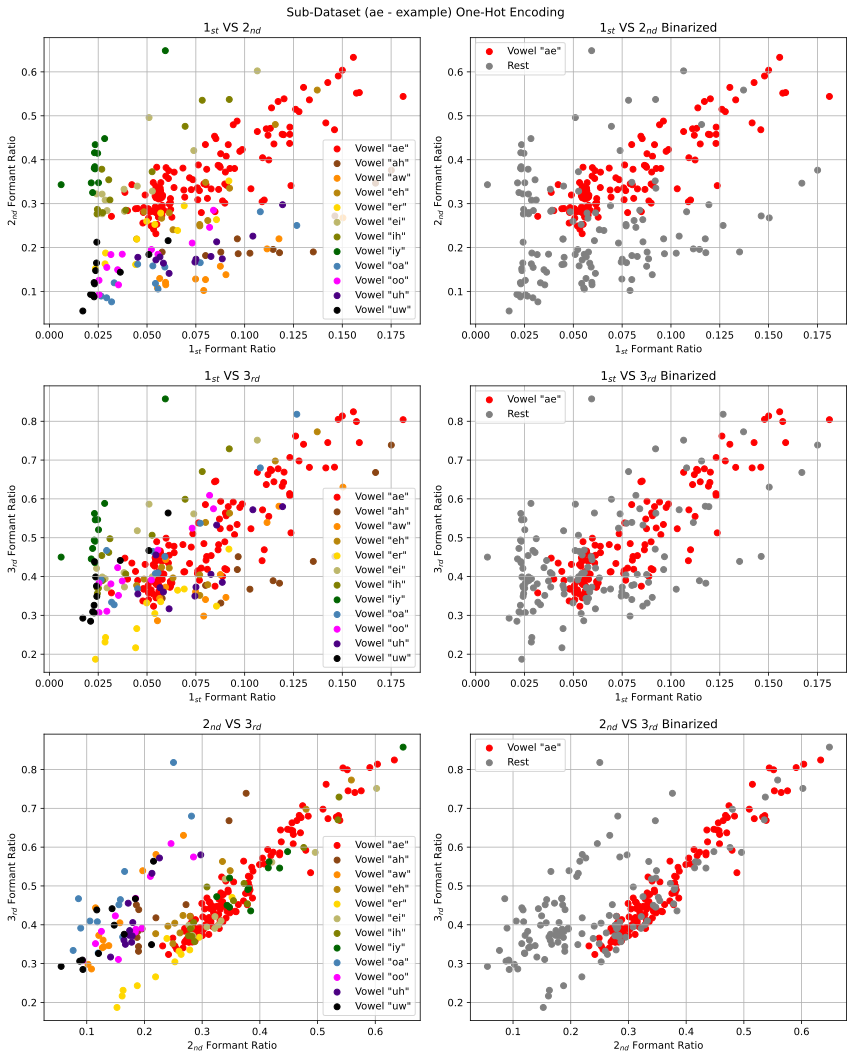

In [ ]:
# Sub-Dataset Plot (previous example)
classes = [n for n in range(len(vowels))]
sub_classes_size = vow_size[sel_class_number] // (len(classes) - 1)

plt.figure(figsize=(12, 15))
plt.suptitle(f'Sub-Dataset ({vowels[sel_class_number]} - example) One-Hot Encoding')

counter = 0
for index in classes:
    if index == sel_class_number:  # Selected Class exception (non increment counter variable)
        first_coords = sub_data[0: vow_size[sel_class_number], 1]
        second_coords = sub_data[0: vow_size[sel_class_number], 2]
        third_coords = sub_data[0: vow_size[sel_class_number], 3]
    else:
        start = vow_size[sel_class_number] + (counter * sub_classes_size)
        end = start + sub_classes_size

        first_coords = sub_data[start : end, 1]
        second_coords = sub_data[start : end, 2]
        third_coords = sub_data[start : end, 3]

        counter +=1

    plt.subplot(3, 2, 1)
    plt.title('$1_{st}$ VS $2_{nd}$')
    plt.scatter(first_coords, second_coords, marker='o', color=colors[index], label=f'Vowel "{vowels[index]}"')
    plt.xlabel('$1_{st}$ Formant Ratio')
    plt.ylabel('$2_{nd}$ Formant Ratio')
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(3, 2, 3)
    plt.title('$1_{st}$ VS $3_{rd}$')
    plt.scatter(first_coords, third_coords, marker='o', color=colors[index], label=f'Vowel "{vowels[index]}"')
    plt.xlabel('$1_{st}$ Formant Ratio')
    plt.ylabel('$3_{rd}$ Formant Ratio')
    plt.legend(loc='best')
    plt.grid(True)

    plt.subplot(3, 2, 5)
    plt.title('$2_{nd}$ VS $3_{rd}$')
    plt.scatter(second_coords, third_coords, marker='o', color=colors[index], label=f'Vowel "{vowels[index]}"')
    plt.xlabel('$2_{nd}$ Formant Ratio')
    plt.ylabel('$3_{rd}$ Formant Ratio')
    plt.legend(loc='best')
    plt.grid(True)

plt.subplot(3, 2, 2)
plt.title('$1_{st}$ VS $2_{nd}$ Binarized')
plt.scatter(sub_data[0: vow_size[sel_class_number], 1], sub_data[0: vow_size[sel_class_number], 2], color=colors[sel_class_number], label=f'Vowel "{vowels[sel_class_number]}"')
plt.scatter(sub_data[vow_size[sel_class_number]:, 1], sub_data[vow_size[sel_class_number]:, 2], color='grey', label=f'Rest')
plt.xlabel('$1_{st}$ Formant Ratio')
plt.ylabel('$2_{nd}$ Formant Ratio')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.title('$1_{st}$ VS $3_{rd}$ Binarized')
plt.scatter(sub_data[0: vow_size[sel_class_number], 1], sub_data[0: vow_size[sel_class_number], 3], color=colors[sel_class_number], label=f'Vowel "{vowels[sel_class_number]}"')
plt.scatter(sub_data[vow_size[sel_class_number]:, 1], sub_data[vow_size[sel_class_number]:, 3], color='grey', label=f'Rest')
plt.xlabel('$1_{st}$ Formant Ratio')
plt.ylabel('$3_{rd}$ Formant Ratio')
plt.legend(loc='best')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.title('$2_{nd}$ VS $3_{rd}$ Binarized')
plt.scatter(sub_data[0: vow_size[sel_class_number], 2], sub_data[0: vow_size[sel_class_number], 3], color=colors[sel_class_number], label=f'Vowel "{vowels[sel_class_number]}"')
plt.scatter(sub_data[vow_size[sel_class_number]:, 2], sub_data[vow_size[sel_class_number]:, 3], color='grey', label=f'Rest')
plt.xlabel('$2_{nd}$ Formant Ratio')
plt.ylabel('$3_{rd}$ Formant Ratio')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.savefig(f'{vowels[sel_class_number]}_class_one_hot_encoding')
plt.show()

In [ ]:
# Train/Test split (auxiliary function)
def train_test_split_aux(features_dataset, labels_dataset, test_perc, tolerance):
    """
    An auxiliary Train_Test_split function (based on Scikit Learn implementation) w. balance tolerance specification
    """
    test_size = int(test_perc / 100 * len(features_dataset))
    train_balance = 0  # Output Training set balance value initialization
    test_balance = 0  # Output Testing set balance value initialization

    min_tol = np.mean(labels_dataset) - tolerance
    max_tol = np.mean(labels_dataset) + tolerance
    print(f'Data Balancing  (TARGET = {np.mean(labels_dataset)} +- {tolerance}): ', end='')

    while (min_tol >= train_balance or train_balance >= max_tol) or (min_tol >= test_balance or test_balance >= max_tol):
        train_data, test_data, train_labels, test_labels = train_test_split(features_dataset, labels_dataset, test_size=test_size, shuffle=True)
        train_balance = np.mean(train_labels)
        test_balance = np.mean(test_labels)
        print('.', end='')
    else:
        print('OK')

    return train_data, test_data, train_labels, test_labels, train_balance, test_balance

# Train-Dev-Test split function
def train_dev_test_split(x_data, y_labels, split_list, tolerance=0.1, output='Loaders', debug=False):
    """
    Compute a Train, Development (Hold-Out) and a Test set split w. PyTorch Dataset conversion (and eventual Loaders initialization)
    """
    if len(split_list) == 3:
        # Train - Dev+Test separation
        print('Training --- Devel/Test SPLIT')
        train_data, testTMP_data, train_labels, testTMP_labels, _, _ = train_test_split_aux(x_data, y_labels, (split_list[1] * 100) + (split_list[2] * 100), tolerance)
        print('----------------------------------')

        # Dev - Test separation
        print('Devel    ---     Test SPLIT')

        split = ((split_list[1] * 100) / np.sum(split_list[1:] * 100)) * 100  # Split in %
        dev_data, test_data, dev_labels, test_labels, _, _ = train_test_split_aux(testTMP_data, testTMP_labels, split, tolerance)
        print('----------------------------------')

        # Tensor Conversion
        train_data_tensor = torch.tensor(train_data).float()
        train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64).squeeze()
        dev_data_tensor = torch.tensor(dev_data).float()
        dev_labels_tensor = torch.tensor(dev_labels, dtype=torch.int64).squeeze()
        test_data_tensor = torch.tensor(test_data).float()
        test_labels_tensor = torch.tensor(test_labels, dtype=torch.int64).squeeze()
        if debug is True:
            print(f'Training Data        Shape: {train_data.shape}')
            print(f'Development Data     Shape: {dev_data.shape}')
            print(f'Testing Data         Shape: {test_data.shape}')

            # Balance Evaluation
            print(f'Training Set       Balance: {np.mean(train_labels)}')
            print(f'Development Set    Balance: {np.mean(dev_labels)}')
            print(f'Testing Set        Balance: {np.mean(test_labels)}')

        if output != 'Loaders':
            return train_data_tensor, train_labels_tensor, dev_data_tensor, dev_labels_tensor, test_data_tensor, test_labels_tensor
        else:
            # PyTorch Dataset Conversion
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels, dtype=torch.int64).squeeze())
            dev_dataset = torch.utils.data.TensorDataset(torch.tensor(dev_data).float(), torch.tensor(dev_labels, dtype=torch.int64).squeeze())
            test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels, dtype=torch.int64).squeeze())

            # DataLoader (Batches) --> Drop-Last control to optimize training
            trainLoader = DataLoader(train_dataset, shuffle=False, batch_size = 32, drop_last=True)
            devLoader = DataLoader(dev_dataset, shuffle=False, batch_size = dev_dataset.tensors[0].shape[0])
            testLoader = DataLoader(test_dataset, shuffle=False, batch_size = test_dataset.tensors[0].shape[0])
            if debug is True:
                print(f'Training Set    Batch Size: {trainLoader.batch_size}')
                print(f'Development Set Batch Size: {devLoader.batch_size}')
                print(f'Testing Set     Batch Size: {testLoader.batch_size}')

            return trainLoader, devLoader, testLoader
    else:
        # Train - Test separation
        print('Training --- Test    SPLIT')
        train_data, test_data, train_labels, test_labels, _, _ = train_test_split_aux(x_data, y_labels, split_list[1] * 100, tolerance, debug=debug)
        print('--------------------------')

        # Tensor Conversion
        train_data_tensor = torch.tensor(train_data).float()
        train_labels_tensor = torch.tensor(train_labels, dtype=torch.int64).squeeze()
        test_data_tensor = torch.tensor(test_data).float()
        test_labels_tensor = torch.tensor(test_labels, dtype=torch.int64).squeeze()
        if debug is True:
            print(f'Training Data        Shape: {train_data.shape}')
            print(f'Testing Data         Shape: {test_data.shape}')

            # Balance Evaluation
            print(f'Training Set    Balance: {np.mean(train_labels)}')
            print(f'Testing Set     Balance: {np.mean(test_labels)}')

        if output != 'Loaders':
            return train_data_tensor, train_labels_tensor, test_data_tensor, test_labels_tensor
        else:
            # PyTorch Dataset Conversion
            train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels, dtype=torch.int64).squeeze())
            test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels, dtype=torch.int64).squeeze())

            # DataLoader (Batches) --> Drop-Last control to optimize training
            trainLoader = DataLoader(train_dataset, shuffle=False, batch_size = 32, drop_last=True)
            testLoader = DataLoader(test_dataset, shuffle=False, batch_size = test_dataset.tensors[0].shape[0])
            if debug is True:
                print(f'Training Set    Batch Size: {trainLoader.batch_size}')
                print(f'Testing Set     Batch Size: {testLoader.batch_size}')

            return trainLoader, testLoader

## **Multi-Layer Perceptron Binary Classifier**

In [ ]:
# Dynamic Multi-Layer Architecture Class (w. units and activation function specification)
class binaryClassifier(nn.Module):                                              # nn.Module: base class to inherit from
    def __init__(self, n_layers, n_units, act_fun):                             # self + attributes (architecture hyper-parameters)
        super().__init__()

        self.layers = nn.ModuleDict()                                           # Dictionary to store Model layers
        self.nLayers = n_layers                                                 # Class instance parameter

        # Input Layer
        if n_layers == 1:
            self.layers['input'] = nn.Linear(3, n_units)                        # Key 'input' layer specification

        else:
            self.layers['input'] = nn.Linear(3, n_units[0])


        # Hidden Layers
        if n_layers == 1:
            self.layers[f'hidden0'] = nn.Linear(n_units, n_units)
        else:
            for i in range(n_layers):
                if i == (n_layers - 1):
                    self.layers[f'hidden{i}'] = nn.Linear(n_units[i], n_units[i])
                else:
                    self.layers[f'hidden{i}'] = nn.Linear(n_units[i], n_units[i + 1])

        # Output Layer
        if n_layers == 1:
            self.layers['output'] = nn.Linear(n_units, 1)                       # Key 'output' layer specification
        else:
            self.layers['output'] = nn.Linear(n_units[n_layers - 1], 1)

        # Activation Function
        self.actfun = act_fun                                                   # Function string-name attribute association

        # Weights initialization (Kaiming He - Normal Distributed)
        for layer in self.layers.keys():
            nn.init.kaiming_normal_(self.layers[layer].weight, mode='fan_in')

    # Forward Pass Method
    def forward(self, x):

        # Activation function object computation
        actfun = getattr(torch.nn, self.actfun)

        # Input Layer pass                                                      --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = actfun()(self.layers['input'](x))

        # Hidden Layers sequential pass                                         --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        for i in range(self.nLayers):
            x = actfun()(self.layers[f'hidden{i}'](x))

        # Output Layer pass                                                     --> Output Weightening (Dot Product) "Linear transform" (Optimizer implement an Output Sigmoid sctivation)
        x = self.layers['output'](x)
        x = nn.Sigmoid()(x)

        return x

In [ ]:
# Train/Test function (w. variable Backpropagation Optimizer Algorithm definition)
def cross_val_train_test(model, optim: str, epochs: int, learning_rate, train_data: torch.Tensor, train_labels: torch.Tensor, test_data: torch.Tensor, test_labels: torch.Tensor, debug: bool = False):
    """
    Train & Test an ANN Classifier w. Binary Cross Entropy Loss computation and the specified Backpropagation Optimizer algorithm
    """
    # Loss Function initialization
    loss_function = nn.BCELoss()

    # Optimizer Algorithm initialization
    optimizer_function = getattr(torch.optim, optim)  # Optimizer function retrieving
    optimizer = optimizer_function(model.parameters(), lr=learning_rate)  # Parameters application (rest are standard initialized)

    # TRAINING Phase
    train_losses = []
    train_accuracies = []

    model.train()  # TRAINING Switch ON

    for i in range(epochs):
        train_predictions = model(train_data)
        train_loss = loss_function(train_predictions.squeeze(), train_labels.squeeze().to(torch.float))
        train_losses.append(train_loss.detach())

        # Backpropagation
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_accuracy = 100 * torch.mean(((train_predictions.squeeze() > 0.5) == train_labels.squeeze()).float())
        train_accuracies.append(train_accuracy.detach())

        if debug is True:
            if i % 100 == 0:
                print(f'Epoch {i} --> Train Accuracy: {train_accuracy.detach()}%')
                print('-------------------------')

    # TESTING Phase
    model.eval()  # EVALUATION Switch ON (TRAINING Switch OFF)
    with torch.no_grad():  # Gradient (and Batch Normalization) deactivation
        test_predictions = model(test_data)
        test_accuracy = 100 * torch.mean(((test_predictions.squeeze() > 0.5) == test_labels.squeeze()).float())

        if debug is True:
            print(f'TEST ACCURACY: {test_accuracy.detach()} %')
            print('-------------------------')

    return test_predictions.detach(), test_accuracy.detach(), train_losses, train_accuracies

# Batch Training function
def mini_batch_train_test(model, optim: str, epochs: int, learning_rate, train_loader, dev_loader, test_loader, debug=False):
    """
    Train & Test an ANN Architecture via Mini-Batch Training (w. Train/Dev/Test PyTorch Loaders) and same params of cross_valid_train_test
    """
    # Loss Function initialization
    loss_function = nn.BCELoss()

    # Optimizer Algorithm initialization
    optimizer_function = getattr(torch.optim, optim)
    optimizer = optimizer_function(model.parameters(), lr=learning_rate)

    # Output list initialization
    train_accuracies = []
    train_losses = []
    dev_accuracies = []

    # TRAINING Phase
    for epoch in range(epochs):
        model.train()  # TRAINING Switch ON

        batch_accuracies = []
        batch_losses = []

        # Training BATCHES Loop
        for data_batch, labels_batch in train_loader:
            train_predictions = model(data_batch)
            train_loss = loss_function(train_predictions.squeeze(), labels_batch.type(torch.int64).float())
            batch_losses.append(train_loss.detach())

            # Backpropagation
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Accuracy
            train_accuracy = 100 * torch.mean(((train_predictions.squeeze() > 0.5) == labels_batch.type(torch.int64).squeeze()).float())

            # Batch Stats appending
            batch_accuracies.append(train_accuracy.detach())
            batch_losses.append(train_loss.detach())

        # Training Stats appending
        train_accuracies.append(np.mean(batch_accuracies))  # Average of Batch Accuracies = Training step accuracy
        train_losses.append(np.mean(batch_losses))  # Average of Batch Losses = Training step Losses

        # EVALUATION (Dev) Phase
        model.eval()
        with torch.no_grad():
            dev_data_batch, dev_labels_batch = next(iter(dev_loader))
            dev_predictions = model(dev_data_batch)

            dev_accuracy = 100 * torch.mean(((dev_predictions.squeeze() > 0.5) == dev_labels_batch.type(torch.int64).squeeze()).float())

            if debug is True:
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} --> DEV ACCURACY: {dev_accuracy.detach():.3f} %')
                    print('--------------------------------')

            # Evaluation accuracy appending
            dev_accuracies.append(dev_accuracy.detach())

    # TEST Phase
    model.eval()
    with torch.no_grad():
        test_data_batch, test_labels_batch = next(iter(test_loader))
        test_predictions = model(test_data_batch)
        test_accuracy = 100 * torch.mean(((test_predictions.squeeze() > 0.5) == test_labels_batch.type(torch.int64).squeeze()).float())

        if debug is True:
            print(f'TEST ACCURACY: {test_accuracy.detach():.2f} %')
            print('--------------------------------------------------------------------')

    return train_accuracies, train_losses, dev_accuracies, test_accuracy.detach()

### **Architecture** optimal *hyper-parameters* estimate

*Grid-Search* (orders of magnitude)
- **Hidden Layers**: $1$
- **Hidden Nodes**: $(10, 50, 100)$
- **Activation Function**: ReLU (*He standard distribution initialization*)

K. He, X. Zhang, S. Ren, J. Sun (2015) - [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/pdf/1502.01852.pdf)

- **Learning Rates**: $(0.001, 0.0001, 0.00001)$
- **Optimizers**: Adam, RMSprop

---

**Root Mean Square Propagation (RMSprop)**

\begin{align}
    w_t \leftarrow w_{t-1} - \frac{\eta}{\sqrt{v_t + \epsilon}}\nabla L
\end{align}

with

\begin{align}
    v_t = (1 - \beta)(\nabla L)^2 + \beta v_{t-1}
\end{align}

Similar to *Momentum* conditioning, but applied to Learning Rate coefficient (instead to Loss function) according to Gradient magnitudes. For this reason we speak about *Dynamic Learning Rate*, where:

- large gradients: implies small LR and smaller steps of minimization
- small gradients ($0 < x < 1$) : implies very large steps of minimization

$\epsilon$ is a standard positive coefficient added to denominator to avoid division by $0$: usually $10^{-8}$

---

**Adaptive Momentum (Adam)**

Probably nowadays best gradient optimizer:

\begin{align}
    w_t \leftarrow w_{t-1} - \frac{\eta}{\sqrt{s_t + \epsilon}}v_t
\end{align}

with

\begin{align}
    v_t = \frac{(1 - \beta_1)\nabla L + \beta_1 v_{t-1}}{1 - \beta_{1}^{t}}
\end{align}

\begin{align}
    s_t = \frac{(1 - \beta_2)(\nabla L)^2 + \beta_2 s_{t-1}}{1 - \beta_{2}^{t}}
\end{align}

A combined form of **Momentum** and **RMSprop** with a dampening normalization factor, learning epoch dependent.

---

Reference: [PyTorch Reference - torch.optim Algorithms](https://pytorch.org/docs/stable/optim.html#algorithms)

In [ ]:
# Experiment Parameters
epochs = 1000  # For each "Batch-Set"
iterations = 3  # A total of 3000 Epochs of Training (3x Batch-Sub-Dataset shuffling)
min_tolerance = 0.1 # ...for sub-dataset balancing

# Architecture Hyper-Parameters
hidden_layers = 1
hidden_nodes = [10, 50, 100]
act_fun = 'ReLU'
learning_rates = [0.001, 0.0001, 0.00001]  # [10^-3, 10^-4, 10^-5]
optimizers = ['Adam', 'RMSprop']

In [ ]:
# AVG. Time 2h
from time import perf_counter
debug=False
experiment_results = np.zeros((len(hidden_nodes), len(learning_rates), len(optimizers), 2))  # Output Matrix initialization (1st layer: Mean Test Accuracies, 2nd Layer: Training Times)

exp_counter = 0
for i in range(len(hidden_nodes)):
    for j in range(len(learning_rates)):
        for k in range(len(optimizers)):

            exp_counter += 1 # Aux variable increment
            print(f'Experiment {exp_counter}: Units (HL): {hidden_nodes[i]}, LR: {learning_rates[j]}, Optimizer: {optimizers[k]}')

            test_accuracies = []  # List of Classes Test Accuracies (Re-initialized for each experiment)
            training_times = []  # List of Classes Training Times (Re-initialized for each experiment)

            # Experiment Routine
            for w in range(len(vowels)):

                # Reset Seed
                torch.manual_seed(SEED)

                # Create Classifier
                binary_classifier = binaryClassifier(1, hidden_nodes[i], act_fun)

                # Iterated (w. Batch-Sets shuffling) Training
                start_timer = perf_counter()
                for iteration in range(iterations):

                    # Dataset processing
                    sub_data, sub_data_labels_bin, _ = one_hot_encoder(sel_class_number=w, dataset=x_data_minmax, debug=debug)
                    print('----------------------------------')
                    trainLoader, devLoader, testLoader = train_dev_test_split(sub_data[:, 1:], sub_data_labels_bin, [0.7, 0.15, 0.15], tolerance=min_tolerance, output='Loaders', debug=debug)

                    # Train/Test Architecture
                    _, _, _, test_accuracy = mini_batch_train_test(binary_classifier, optimizers[k], epochs, learning_rates[j], trainLoader, devLoader, testLoader, debug)
                    print(f'Sub-Net "{vowels[w]}" Partial-{iteration + 1} TEST ACCURACY: {test_accuracy:.2f}%')

                stop_timer = perf_counter()

                # Class Outputs append
                test_accuracies.append(test_accuracy) # in %
                training_times.append(stop_timer - start_timer) # in sec.
                print('---------------------------------------------------------------------')

            print(f'Classes MEAN ACCURACY: {np.mean(test_accuracies)}%')
            print(f'Classes Mean Training Runtime: {np.mean(training_times)}sec.')

            experiment_results[i, j, k, 0] = np.mean(test_accuracies)  # Average of 12 classes Accuracies
            experiment_results[i, j, k, 1] = np.mean(training_times)  # Average of 12 classes Training Times

            print('------------------------------------------------------------------------------------------------------')

# Outputs Save
np.savez_compressed(file='./architecture_grid_search',
                    avg_test_accuracies=experiment_results[:, :, :, 0],
                    avg_training_times=experiment_results[:, :, :, 1])

Output streaming troncato alle ultime 5000 righe.
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5129151291512916 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.5308641975308642 +- 0.1): .OK
----------------------------------
Sub-Net "ih" Partial-3 TEST ACCURACY: 87.50%
---------------------------------------------------------------------
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5120967741935484 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.4189189189189189 +- 0.1): .OK
----------------------------------
Sub-Net "iy" Partial-1 TEST ACCURACY: 100.00%
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5120967741935484 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.5540540540540541 +- 0.1): ..OK
---------------------

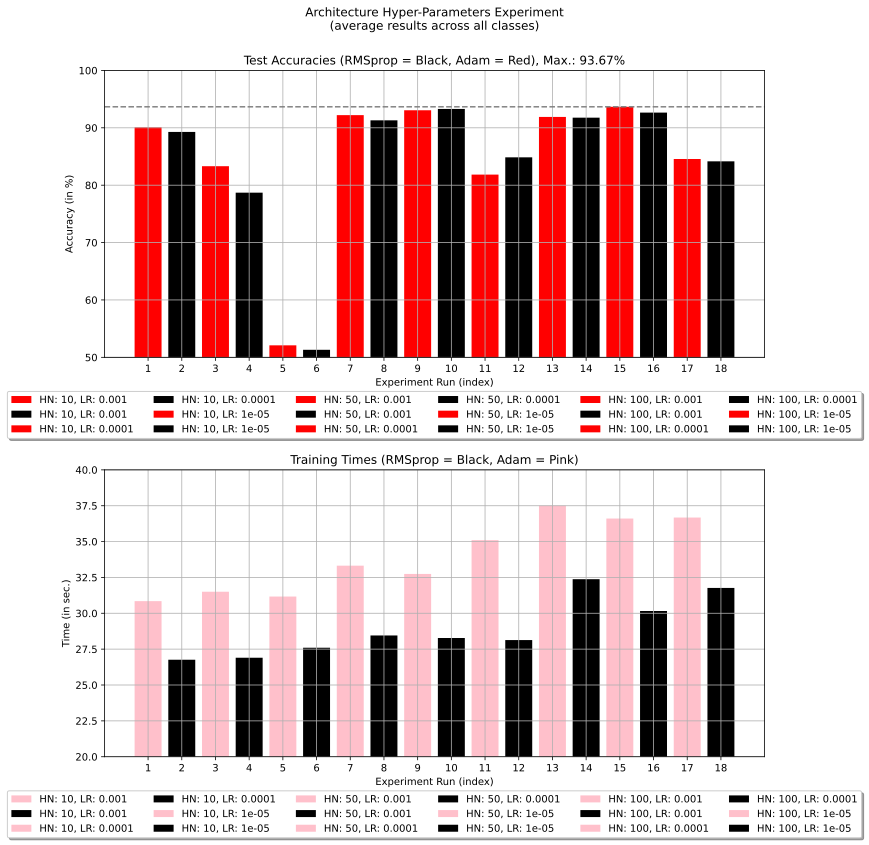

In [ ]:
# Architecture Grid-Search Experiment Plot
experiment_data = np.load(file='./architecture_grid_search.npz')

plt.figure(figsize=(12, 12))
plt.suptitle('Architecture Hyper-Parameters Experiment\n(average results across all classes)\n')

plt.subplot(2, 1, 1)
counter = 1
for i in range(experiment_data['avg_test_accuracies'].shape[0]):
    for j in range(experiment_data['avg_test_accuracies'].shape[1]):
        for k in range(experiment_data['avg_test_accuracies'].shape[2]):
            if k == 1:
                plt.bar(counter, experiment_data['avg_test_accuracies'][i, j, k], color='k', label=f'HN: {hidden_nodes[i]}, LR: {learning_rates[j]}')
            else:
                plt.bar(counter, experiment_data['avg_test_accuracies'][i, j, k], color='r', label=f'HN: {hidden_nodes[i]}, LR: {learning_rates[j]}')

            counter += 1

max_accuracy = np.max(experiment_data['avg_test_accuracies'])
plt.axhline(max_accuracy, color='grey', linestyle='--')
plt.title(f'Test Accuracies (RMSprop = Black, Adam = Red), Max.: {max_accuracy:.2f}%')
plt.xlabel('Experiment Run (index)')
plt.xticks([(n + 1) for n in range(18)], [(n + 1) for n in range(18)])
plt.ylabel('Accuracy (in %)')
plt.ylim([50, 100])
plt.grid()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=6)

plt.subplot(2, 1, 2)
counter = 1
for i in range(experiment_data['avg_training_times'].shape[0]):
    for j in range(experiment_data['avg_training_times'].shape[1]):
        for k in range(experiment_data['avg_training_times'].shape[2]):
            if k == 1:
                plt.bar(counter, experiment_data['avg_training_times'][i, j, k], color='k', label=f'HN: {hidden_nodes[i]}, LR: {learning_rates[j]}')

            else:
                plt.bar(counter, experiment_data['avg_training_times'][i, j, k], color='pink', label=f'HN: {hidden_nodes[i]}, LR: {learning_rates[j]}')

            counter += 1

plt.title('Training Times (RMSprop = Black, Adam = Pink)')
plt.xlabel('Experiment Run (index)')
plt.xticks([(n + 1) for n in range(18)], [(n + 1) for n in range(18)])
plt.ylabel('Time (in sec.)')
plt.ylim([20, 40])
plt.grid()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=6)

plt.tight_layout()
plt.savefig('architecture_grid_search')
plt.show()

In [ ]:
# Best Test Accuracy inspection
best_run_acc = experiment_data['avg_test_accuracies'][2, 1, 0]
best_run_time = experiment_data['avg_training_times'][2, 1, 0]
print(f'Run 15 (Adam Optimizer): {best_run_acc:.2f}% in {best_run_time:.2f}sec. (per class)')

Run 15 (Adam Optimizer): 93.67% in 36.60sec. (per class)


### **Architecture Optimization**

```
Multi-Layer Perceptron
- Input Layer: 3 features [formant ratios, min-max normalized]
- Hidden Layer: 100 units
- Output Layer: 1 normalized probability
- Learning Rate: 0.0001 (10^-4)
- Optimizer : Adam (Adaptive Momentum)

- Mini-Batch Training:
    . Re-iterated Sub-Dataset Shuffling
    . Batch size = 32
```

- **Bias Initialization**: $0$
- **Regularization**: DropOut, Batch-Normalization, L2 Loss Regularization

#### **DropOut**

Probabilistic method to "mute" (sparsing) learning inference of arbitrary nodes during each epoch. It aims to uniform learning patterns and avoid mnemonic recognition/association of data examples.

- N. Srivastava, G. Hinton, A. Krizhevsky, I. Sutskever, R. Salakhutdinov (2014) - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf)

In [ ]:
# Dynamic Multi-Layer Architecture Class (w. units, activation function and DropOut Rate specification)
class binaryClassifier_dropout(nn.Module):                                      # nn.Module: base class to inherit from
    def __init__(self, n_layers, n_units, act_fun, rate_in, rate_hidden):       # self + attributes (architecture hyper-parameters)
        super().__init__()

        self.layers = nn.ModuleDict()                                           # Dictionary to store Model layers
        self.nLayers = n_layers                                                 # Class instance parameter

        # Input Layer
        self.layers['input'] = nn.Linear(3, n_units)                            # Key 'input' layer specification

        # Hidden Layers
        self.layers[f'hidden'] = nn.Linear(n_units, n_units)

        # Output Layer
        self.layers['output'] = nn.Linear(n_units, 1)                           # Key 'output' layer specification

        # Activation Function
        self.actfun = act_fun                                                   # Function string-name attribute association

        # Dropout Parameter
        self.dr_in = rate_in
        self.dr_hidden = rate_hidden

        # Weights & Bias initialization
        for layer in self.layers.keys():
            nn.init.kaiming_normal_(self.layers[layer].weight, mode='fan_in')   # Kaiming He - Normal Distributed (ReLU specific)
        for layer in self.layers.keys():
            self.layers[layer].bias.data.fill_(0.)                              # Bias initialization

    # Forward Pass Method
    def forward(self, x):

        # Activation function object computation
        actfun = getattr(torch.nn, self.actfun)

        # Input Layer pass                                                      --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = actfun()(self.layers['input'](x))
        x = F.dropout(x, p=self.dr_in, training=self.training)                  # Activate DropOut only when Model Training == True

        # Hidden Layers sequential pass                                         --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = actfun()(self.layers[f'hidden'](x))
        x = F.dropout(x, p=self.dr_hidden, training=self.training)              # Same as "Input pass"

        # Output Layer pass                                                     --> Output Weightening (Dot Product) "Linear transform" (Optimizer implement an Output Sigmoid sctivation)
        x = self.layers['output'](x)
        x = nn.Sigmoid()(x)

        return x

In [ ]:
# Experiment Parameters
epochs = 1000  # For each "Batch-Set"
iterations = 6  # A total of 6000 Epochs of Training (6x Batch-Sub-Dataset shuffling) --> w. Early Stopping
min_tolerance = 0.1 # ...for sub-dataset balancing

# Architecture Hyper-Parameters
hidden_layer = 1
hidden_nodes = 100
act_fun = 'ReLU'
learning_rate = 0.0001  # 10^-4
optimizer = 'Adam'

# DropOut Regularization Parameters
dropout_rates_in = [0.8, 0.9]
dropout_rates_hidden = (np.arange(5) / 10.) + 0.5

In [ ]:
# AVG. Time 1h 30min
from time import perf_counter
debug=False
experiment_results = np.zeros((len(dropout_rates_in), len(dropout_rates_hidden), 2))

exp_counter = 0
for i in range(len(dropout_rates_in)):
    for j in range(len(dropout_rates_hidden)):
        exp_counter += 1
        print(f'Experiment {exp_counter}: DropOut Input: {dropout_rates_in[i]}, DropOut Hidden: {dropout_rates_hidden[j]}')

        test_accuracies = []  # List of Classes Test Accuracies (Re-initialized for each experiment)
        training_times = []  # List of Classes Training Times (Re-initialized for each experiment)

        # Experiment Routine
        for k in range(len(vowels)):

            # Reset Seed
            torch.manual_seed(SEED)

            # Create Classifier
            binary_classifier = binaryClassifier_dropout(1, hidden_nodes, act_fun, dropout_rates_in[i], dropout_rates_hidden[j])

            # Iterated (w. Batch-Sets shuffling) Training
            iteration = 0

            start_timer = perf_counter()
            while iteration < iterations:

                # Dataset processing
                sub_data, sub_data_labels_bin, _ = one_hot_encoder(sel_class_number=k, dataset=x_data_minmax, debug=debug)
                print('----------------------------------')
                trainLoader, devLoader, testLoader = train_dev_test_split(sub_data[:, 1:], sub_data_labels_bin, [0.7, 0.15, 0.15], tolerance=min_tolerance, output='Loaders', debug=debug)

                # Train/Test Architecture
                _, _, _, test_accuracy = mini_batch_train_test(binary_classifier, optimizer, epochs, learning_rate, trainLoader, devLoader, testLoader, debug)
                print(f'Sub-Net "{vowels[k]}" Partial-{iteration + 1} TEST ACCURACY: {test_accuracy:.2f}%')

                if test_accuracy > 93.67:  # If specific class instance overshot class mean accuracy
                    iteration += 1
                    print(f'Training STOP {iteration}--------------------')
                    break  # Early stop

                iteration += 1  # Go to next Batch training iteration

            stop_timer = perf_counter()

            # Class Outputs append
            test_accuracies.append(test_accuracy) # in %
            training_times.append(stop_timer - start_timer) # in sec.
            print('---------------------------------------------------------------------')

        print(f'Classes MEAN ACCURACY: {np.mean(test_accuracies)}%')
        print(f'Classes Mean Training Runtime: {np.mean(training_times)}sec.')

        experiment_results[i, j, 0] = np.mean(test_accuracies)  # Average of 12 classes Accuracies
        experiment_results[i, j, 1] = np.mean(training_times)  # Average of 12 classes Training Times

        print('------------------------------------------------------------------------------------------------------')

# Outputs Save
np.savez_compressed(file='./dropout_grid_search',
                    avg_test_accuracies=experiment_results[:, :, 0],
                    avg_training_times=experiment_results[:, :, 1])

Output streaming troncato alle ultime 5000 righe.
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.425 +- 0.1): .OK
----------------------------------
Sub-Net "aw" Partial-4 TEST ACCURACY: 97.50%
Training STOP 4--------------------
---------------------------------------------------------------------
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5129151291512916 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.4567901234567901 +- 0.1): .OK
----------------------------------
Sub-Net "eh" Partial-1 TEST ACCURACY: 70.00%
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5129151291512916 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.5925925925925926 +- 0.1): .OK
----------------------------------
Sub-Net "eh" Partial-2 TEST ACCURACY: 90.00%
----------------------------------
Training

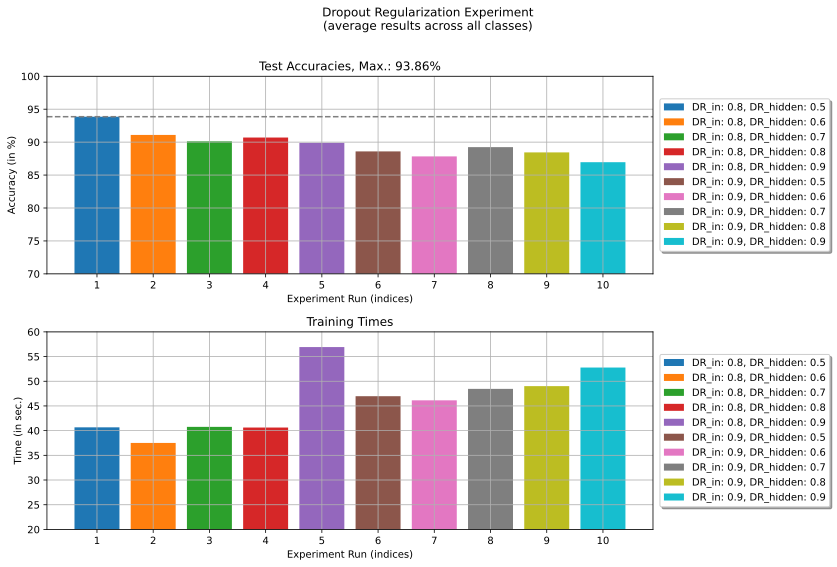

In [ ]:
# DropOut Grid-Search Experiment Plot
experiment_data = np.load(file='./dropout_grid_search.npz')

plt.figure(figsize=(12, 8))
plt.suptitle('Dropout Regularization Experiment\n(average results across all classes)\n')

counter = 0
plt.subplot(2, 1, 1)
for i in range(experiment_data['avg_test_accuracies'].shape[0]):
    for j in range(experiment_data['avg_test_accuracies'].shape[1]):
        plt.bar(counter + 1, experiment_data['avg_test_accuracies'][i, j], label=f'DR_in: {dropout_rates_in[i]}, DR_hidden: {dropout_rates_hidden[j]}')
        counter += 1

max_accuracy = np.max(experiment_data['avg_test_accuracies'])
plt.axhline(max_accuracy, color='grey', linestyle='--')
plt.title(f'Test Accuracies, Max.: {max_accuracy:.2f}%')
plt.xlabel('Experiment Run (indices)')
plt.xticks([(n + 1) for n in range(10)], [(n + 1) for n in range(10)])
plt.ylabel('Accuracy (in %)')
plt.ylim([70, 100])
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), fancybox=True, shadow=True, ncol=1)

counter = 0
plt.subplot(2, 1, 2)
for i in range(experiment_data['avg_training_times'].shape[0]):
    for j in range(experiment_data['avg_training_times'].shape[1]):
        plt.bar(counter + 1, experiment_data['avg_training_times'][i, j], label=f'DR_in: {dropout_rates_in[i]}, DR_hidden: {dropout_rates_hidden[j]}')
        counter += 1

plt.title(f'Training Times')
plt.xlabel('Experiment Run (indices)')
plt.xticks([(n + 1) for n in range(10)], [(n + 1) for n in range(10)])
plt.ylabel('Time (in sec.)')
plt.ylim([20, 60])
plt.grid()
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), fancybox=True, shadow=True, ncol=1)

plt.tight_layout()
plt.savefig('dropout_grid_search')
plt.show()

In [ ]:
# Best Test Accuracy inspection
best_run_acc = experiment_data['avg_test_accuracies'][0, 0]
best_run_time = experiment_data['avg_training_times'][0, 0]
print(f'Adam + DropOut: {best_run_acc:.2f}% in {best_run_time:.2f}sec. (per class)')

Run 15 (Adam + DropOut): 93.86% in 37.50sec. (per class)


#### **Batch Normalization**

A form of regularization applied to layers inputs, in order to avoid covariance shift, vanishing or exploding gradients.

\begin{align}
    \hat{y} = \sigma(\tilde{x}^Tw)
\end{align}

with

\begin{align}
    \tilde{x} = \gamma x + \beta
\end{align}

with $\gamma$ and $\beta$ respectively a scaling and shifting coefficient, learned by the model itself during training phase, while $\tilde{x}$ is a normalized "raw input" to the n-Layer.

- S. Ioffe, C. Szegedy (2015) - [*Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*](https://docs.google.com/viewer?url=http%3A%2F%2Fresearch.google.com%2Fpubs%2Farchive%2F43442.pdf)

In [ ]:
# Dynamic Multi-Layer Architecture Class (w. units, activation function, DropOut Rate specification)
class binaryClassifier_batchnorm(nn.Module):                                      # nn.Module: base class to inherit from
    def __init__(self, n_layers, n_units, act_fun, rate_in, rate_hidden):         # self + attributes (architecture hyper-parameters)
        super().__init__()

        self.layers = nn.ModuleDict()                                             # Dictionary to store Model layers
        self.nLayers = n_layers                                                   # Class instance parameter

        # Input Layer
        self.layers['input'] = nn.Linear(3, n_units)                              # Key 'input' layer specification

        # Hidden Layers
        self.layers[f'hidden'] = nn.Linear(n_units, n_units)
        self.layers[f'batch_norm'] = nn.BatchNorm1d(n_units)

        # Output Layer
        self.layers['output'] = nn.Linear(n_units, 1)                             # Key 'output' layer specification

        # Activation Function
        self.actfun = act_fun                                                     # Function string-name attribute association

        # Dropout Parameter
        self.dr_in = rate_in
        self.dr_hidden = rate_hidden

        # Weights & Bias initialization
        for layer in self.layers.keys():
            try:
                nn.init.kaiming_normal_(self.layers[layer].weight, mode='fan_in') # Kaiming He - Normal Distributed (ReLU specific)
            except:
                pass                                                              # Batch_norm Layer can't be initialized
        for layer in self.layers.keys():
            self.layers[layer].bias.data.fill_(0.)                                # Bias initialization (0.)

    # Forward Pass Method
    def forward(self, x):

        # Activation function object computation
        actfun = getattr(torch.nn, self.actfun)

        # Input Layer pass                                                        --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = actfun()(self.layers['input'](x))
        x = F.dropout(x, p=self.dr_in, training=self.training)                    # Activate DropOut only when Model Training == True

        # Hidden Layers sequential pass                                           --> Weightening (Dot Product) "Linear transform" + "Non linear function" transform application
        x = self.layers[f'batch_norm'](x)                                         # Apply batch normalization before hidden layer
        x = actfun()(self.layers[f'hidden'](x))
        x = F.dropout(x, p=self.dr_hidden, training=self.training)                # Same as "Input pass"

        # Output Layer pass                                                       --> Output Weightening (Dot Product) "Linear transform" (Optimizer implement an Output Sigmoid sctivation)
        x = self.layers['output'](x)
        x = nn.Sigmoid()(x)

        return x

In [ ]:
# Experiment Parameters
epochs = 1000  # For each "Batch-Set"
iterations = 10  # A total of 10000 Epochs of Training (10x Batch-Sub-Dataset shuffling) --> w. Early Stopping
min_tolerance = 0.1 # ...for sub-dataset balancing

# Architecture Hyper-Parameters
hidden_layer = 1
hidden_nodes = 100
act_fun = 'ReLU'
learning_rates = [0.001, 0.0001, 0.00001]  # Try increasing and reducing actual LR
optimizer = 'Adam'

# Regularization Hyper-Parameters
dropout_rate_in = 0.8
dropout_rate_hidden = 0.5

In [ ]:
# AVG. Time 40min.
from time import perf_counter
debug=False
experiment_results = np.zeros((len(learning_rates), 2))


for i in range(len(learning_rates)):
    print(f'Experiment {i + 1}: LR: {learning_rates[i]}')

    test_accuracies = []  # List of Classes Test Accuracies (Re-initialized for each experiment)
    training_times = []  # List of Classes Training Times (Re-initialized for each experiment)

    # Experiment Routine
    for k in range(len(vowels)):

        # Reset Seed
        torch.manual_seed(SEED)

        # Create Classifier
        binary_classifier = binaryClassifier_batchnorm(1, hidden_nodes, act_fun, dropout_rate_in, dropout_rate_hidden)

        # Iterated (w. Batch-Sets shuffling) Training
        iteration = 0

        start_timer = perf_counter()
        while iteration < iterations:

            # Dataset processing
            sub_data, sub_data_labels_bin, _ = one_hot_encoder(sel_class_number=k, dataset=x_data_minmax, debug=debug)
            print('----------------------------------')
            trainLoader, devLoader, testLoader = train_dev_test_split(sub_data[:, 1:], sub_data_labels_bin, [0.7, 0.15, 0.15], tolerance=min_tolerance, output='Loaders', debug=debug)

            # Train/Test Architecture
            _, _, _, test_accuracy = mini_batch_train_test(binary_classifier, optimizer, epochs, learning_rates[i], trainLoader, devLoader, testLoader, debug)
            print(f'Sub-Net "{vowels[k]}" Partial-{iteration + 1} TEST ACCURACY: {test_accuracy:.2f}%')

            if test_accuracy > 93.86:  # If specific class instance overshot previous class mean accuracy
                iteration += 1
                print(f'Training STOP {iteration}--------------------')
                break  # Early stop

            iteration += 1  # Go to next Batch training iteration

        stop_timer = perf_counter()

        # Class Outputs append
        test_accuracies.append(test_accuracy) # in %
        training_times.append(stop_timer - start_timer) # in sec.
        print('---------------------------------------------------------------------')

    print(f'Classes MEAN ACCURACY: {np.mean(test_accuracies)}%')
    print(f'Classes Mean Training Runtime: {np.mean(training_times)}sec.')

    experiment_results[i, 0] = np.mean(test_accuracies)  # Average of 12 classes Accuracies
    experiment_results[i, 1] = np.mean(training_times)  # Average of 12 classes Training Times

    print('------------------------------------------------------------------------------------------------------')

# Outputs Save
np.savez_compressed(file='./batch_norm_lr',
                avg_test_accuracies=experiment_results[:, 0],
                avg_training_times=experiment_results[:, 1])

Experiment 0: LR: 0.001
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.4050632911392405 +- 0.1): ..OK
----------------------------------
Sub-Net "ae" Partial-1 TEST ACCURACY: 71.79%
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.4936708860759494 +- 0.1): .OK
----------------------------------
Sub-Net "ae" Partial-2 TEST ACCURACY: 76.92%
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.5569620253164557 +- 0.1): .OK
----------------------------------
Sub-Net "ae" Partial-3 TEST ACCURACY: 84.62%
---

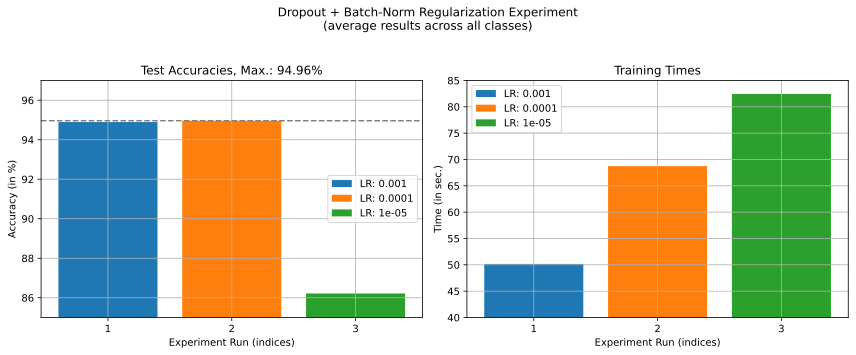

In [ ]:
# Batch Normalization Experiment Plot
experiment_data = np.load(file='./batch_norm_lr.npz')

plt.figure(figsize=(12, 5))
plt.suptitle('Dropout + Batch-Norm Regularization Experiment\n(average results across all classes)\n')

counter = 0
plt.subplot(1, 2, 1)
for i in range(experiment_data['avg_test_accuracies'].shape[0]):
    plt.bar(i + 1, experiment_data['avg_test_accuracies'][i], label=f'LR: {learning_rates[i]}')
    counter += 1

max_accuracy = np.max(experiment_data['avg_test_accuracies'])
plt.axhline(max_accuracy, color='grey', linestyle='--')
plt.title(f'Test Accuracies, Max.: {max_accuracy:.2f}%')
plt.xlabel('Experiment Run (indices)')
plt.xticks([(n + 1) for n in range(3)], [(n + 1) for n in range(3)])
plt.ylabel('Accuracy (in %)')
plt.ylim([85, 97])
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
for i in range(experiment_data['avg_training_times'].shape[0]):
    plt.bar(i + 1, experiment_data['avg_training_times'][i], label=f'LR: {learning_rates[i]}')

plt.title(f'Training Times')
plt.xlabel('Experiment Run (indices)')
plt.xticks([(n + 1) for n in range(3)], [(n + 1) for n in range(3)])
plt.ylabel('Time (in sec.)')
plt.ylim([40, 85])
plt.grid()
plt.legend(loc='best')

plt.tight_layout()
plt.savefig('batch_norm_lr')
plt.show()

In [ ]:
# Best Test Accuracy inspection
best_run_acc = experiment_data['avg_test_accuracies'][1]
best_run_time = experiment_data['avg_training_times'][1]
print(f'Adam + DropOut + Batch-Norm: {best_run_acc:.2f}% in {best_run_time:.2f}sec. (per class)')

Adam + DropOut + Batch-Norm: 94.96% in 68.73sec. (per class)


#### **L2 (Ridge) Penalty**

$L2$, also called "*Ridge regression*" or "*weight decay*" regularization it's expressed as:

\begin{align}
        J = \frac{1}{n}\sum_{i=1}^{n}L(\hat{y}_i, y_i) + \lambda||w_i||_2^2
\end{align}

where: $||w_i||_2^2 = w^Tw$

$\lambda$ is a scalar coefficient, also called "regularization parameter/coefficient" and is usually expressed as:

\begin{align}
        \lambda = \frac{\alpha}{2m}
\end{align}

where $m$ is the number of weights and $||w||$ represent the vector magnitude (norm) of weights.

Generally, we tend to prefer a relatively large value from the left term (the summation) and a relatively small value from the rgularization term in order to minimize cost function adding weights features itself.

[*Wikipedia*](https://en.wikipedia.org/wiki/Ridge_regression)

In [ ]:
# Batch Training function (w. Adam Optimizer & L2 penalty term) Re-Definition
def mini_batch_train_test(model, weight_decay, epochs: int, learning_rate, train_loader, dev_loader, test_loader, debug=False):
    """
    Train & Test an ANN Architecture via Mini-Batch Training (w. Train/Dev/Test PyTorch Loaders) and Adam Backpropagation Optimizer
    """
    # Loss Function initialization
    loss_function = nn.BCELoss()

    # Optimizer Algorithm initialization
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Output list initialization
    train_accuracies = []
    train_losses = []
    dev_accuracies = []

    # TRAINING Phase
    for epoch in range(epochs):
        model.train()  # TRAINING Switch ON

        batch_accuracies = []
        batch_losses = []

        # Training BATCHES Loop
        for data_batch, labels_batch in train_loader:
            train_predictions = model(data_batch)
            train_loss = loss_function(train_predictions.squeeze(), labels_batch.type(torch.int64).float())
            batch_losses.append(train_loss.detach())

            # Backpropagation
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Accuracy
            train_accuracy = 100 * torch.mean(((train_predictions.squeeze() > 0.5) == labels_batch.type(torch.int64).squeeze()).float())

            # Batch Stats appending
            batch_accuracies.append(train_accuracy.detach())
            batch_losses.append(train_loss.detach())

        # Training Stats appending
        train_accuracies.append(np.mean(batch_accuracies))  # Average of Batch Accuracies = Training step accuracy
        train_losses.append(np.mean(batch_losses))  # Average of Batch Losses = Training step Losses

        # EVALUATION (Dev) Phase
        model.eval()
        with torch.no_grad():
            dev_data_batch, dev_labels_batch = next(iter(dev_loader))
            dev_predictions = model(dev_data_batch)

            dev_accuracy = 100 * torch.mean(((dev_predictions.squeeze() > 0.5) == dev_labels_batch.type(torch.int64).squeeze()).float())

            if debug is True:
                if epoch % 100 == 0:
                    print(f'Epoch {epoch} --> DEV ACCURACY: {dev_accuracy.detach():.3f} %')
                    print('--------------------------------')

            # Evaluation accuracy appending
            dev_accuracies.append(dev_accuracy.detach())

    # TEST Phase
    model.eval()
    with torch.no_grad():
        test_data_batch, test_labels_batch = next(iter(test_loader))
        test_predictions = model(test_data_batch)
        test_accuracy = 100 * torch.mean(((test_predictions.squeeze() > 0.5) == test_labels_batch.type(torch.int64).squeeze()).float())

        if debug is True:
            print(f'TEST ACCURACY: {test_accuracy.detach():.2f} %')
            print('--------------------------------------------------------------------')

    return train_accuracies, train_losses, dev_accuracies, test_accuracy.detach()

In [ ]:
# Experiment Parameters
epochs = 1000  # For each "Batch-Set"
iterations = 10  # A total of 10000 Epochs of Training (10x Batch-Sub-Dataset shuffling) --> w. Early Stopping
min_tolerance = 0.1 # ...for sub-dataset balancing

# Architecture Hyper-Parameters
hidden_layer = 1
hidden_nodes = 100
act_fun = 'ReLU'
learning_rate = 0.0001
optimizer = 'Adam'

# Regularization Hyper-Parameters
dropout_rate_in = 0.8
dropout_rate_hidden = 0.5
l2_lambda = np.logspace(-2, -4, num=3, base=10)  # [10^-2, 10^-3, 10^-4]

In [ ]:
# AVG. Time 30min.
from time import perf_counter
debug=False
experiment_results = np.zeros((len(l2_lambda), 2))


for i in range(len(l2_lambda)):
    print(f'Experiment {i + 1}: L2_Lambda (Weight Decay): {l2_lambda[i]}')

    test_accuracies = []  # List of Classes Test Accuracies (Re-initialized for each experiment)
    training_times = []  # List of Classes Training Times (Re-initialized for each experiment)

    # Experiment Routine
    for k in range(len(vowels)):

        # Reset Seed
        torch.manual_seed(SEED)

        # Create Classifier
        binary_classifier = binaryClassifier_batchnorm(1, hidden_nodes, act_fun, dropout_rate_in, dropout_rate_hidden)

        # Iterated (w. Batch-Sets shuffling) Training
        iteration = 0

        start_timer = perf_counter()
        while iteration < iterations:

            # Dataset processing
            sub_data, sub_data_labels_bin, _ = one_hot_encoder(sel_class_number=k, dataset=x_data_minmax, debug=debug)
            print('----------------------------------')
            trainLoader, devLoader, testLoader = train_dev_test_split(sub_data[:, 1:], sub_data_labels_bin, [0.7, 0.15, 0.15], tolerance=min_tolerance, output='Loaders', debug=debug)

            # Train/Test Architecture
            _, _, _, test_accuracy = mini_batch_train_test(binary_classifier, l2_lambda[i], epochs, learning_rate, trainLoader, devLoader, testLoader, debug)
            print(f'Sub-Net "{vowels[k]}" Partial-{iteration + 1} TEST ACCURACY: {test_accuracy:.2f}%')

            if test_accuracy > 94.96:  # If specific class instance overshot previous class mean accuracy
                iteration += 1
                print(f'Training STOP {iteration}--------------------')
                break  # Early stop

            iteration += 1  # Go to next Batch training iteration

        stop_timer = perf_counter()

        # Class Outputs append
        test_accuracies.append(test_accuracy) # in %
        training_times.append(stop_timer - start_timer) # in sec.
        print('---------------------------------------------------------------------')

    print(f'Classes MEAN ACCURACY: {np.mean(test_accuracies)}%')
    print(f'Classes Mean Training Runtime: {np.mean(training_times)}sec.')

    experiment_results[i, 0] = np.mean(test_accuracies)  # Average of 12 classes Accuracies
    experiment_results[i, 1] = np.mean(training_times)  # Average of 12 classes Training Times

    print('------------------------------------------------------------------------------------------------------')

# Outputs Save
np.savez_compressed(file='./L2_grid_search',
                avg_test_accuracies=experiment_results[:, 0],
                avg_training_times=experiment_results[:, 1])

Experiment 1: L2_Lambda (Weight Decay): 0.01
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.5316455696202531 +- 0.1): .OK
----------------------------------
Sub-Net "ae" Partial-1 TEST ACCURACY: 89.74%
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.4430379746835443 +- 0.1): .OK
----------------------------------
Sub-Net "ae" Partial-2 TEST ACCURACY: 79.49%
----------------------------------
Training --- Devel/Test SPLIT
Data Balancing  (TARGET = 0.5037593984962406 +- 0.1): .OK
----------------------------------
Devel    ---     Test SPLIT
Data Balancing  (TARGET = 0.4936708860759494 +- 0.1): .OK
----------------------------------
Sub-Net "ae" Partial-3 TEST 

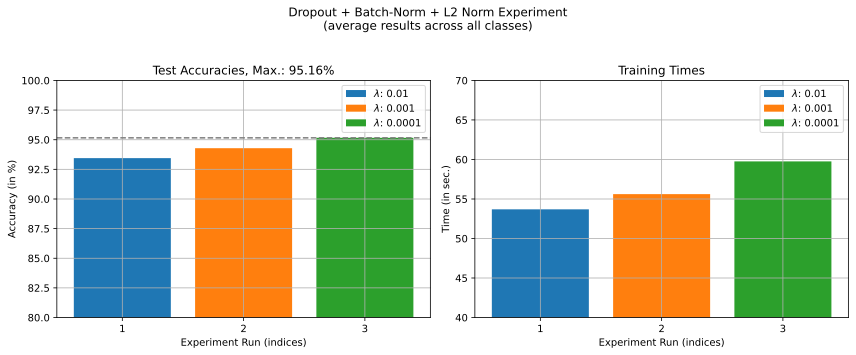

In [ ]:
# L2 Normalization Experiment Plot
experiment_data = np.load(file='./L2_grid_search.npz')

plt.figure(figsize=(12, 5))
plt.suptitle('Dropout + Batch-Norm + L2 Norm Experiment\n(average results across all classes)\n')

counter = 0
plt.subplot(1, 2, 1)
for i in range(experiment_data['avg_test_accuracies'].shape[0]):
    plt.bar(i + 1, experiment_data['avg_test_accuracies'][i], label=f'$\lambda$: {l2_lambda[i]}')
    counter += 1

max_accuracy = np.max(experiment_data['avg_test_accuracies'])
plt.axhline(max_accuracy, color='grey', linestyle='--')
plt.title(f'Test Accuracies, Max.: {max_accuracy:.2f}%')
plt.xlabel('Experiment Run (indices)')
plt.xticks([(n + 1) for n in range(3)], [(n + 1) for n in range(3)])
plt.ylabel('Accuracy (in %)')
plt.ylim([80, 100])
plt.grid()
plt.legend(loc='best')

plt.subplot(1, 2, 2)
for i in range(experiment_data['avg_training_times'].shape[0]):
    plt.bar(i + 1, experiment_data['avg_training_times'][i], label=f'$\lambda$: {l2_lambda[i]}')

plt.title(f'Training Times')
plt.xlabel('Experiment Run (indices)')
plt.xticks([(n + 1) for n in range(3)], [(n + 1) for n in range(3)])
plt.ylabel('Time (in sec.)')
plt.ylim([40, 70])
plt.grid()
plt.legend(loc='best')

plt.tight_layout()
plt.savefig('L2_grid_search')
plt.show()

In [ ]:
# Best Test Accuracy inspection
best_run_acc = experiment_data['avg_test_accuracies'][2]
best_run_time = experiment_data['avg_training_times'][2]
print(f'Adam + DropOut + Batch-Norm + L2: {best_run_acc:.2f}% in {best_run_time:.2f}sec. (per class)')

Adam + DropOut + Batch-Norm + L2: 95.16% in 59.76sec. (per class)


## *Further improvements*

```
Multi-Layer Perceptron
- Input Layer: 3 features [formant ratios, min-max normalized]
- Hidden Layer: 100 units
- Output Layer: 1 normalized probability
- Learning Rate: 0.0001 (10^-4)
- Optimizer: Adam (Adaptive Momentum)

- Mini-Batch Training:
    . Re-iterated Sub-Dataset Shuffling
    . Early Stopping (Test Accuracy driven)
    . Batch size = 32

- Regularization:
    . Weight Decay (L2 Penalty): 0.0001 (10^-4)
    . DropOut:
        * Input Layer Drop Rate: 0.8
        * Hidden Layer Drop Rate: 0.5
    . Batch Normalization
```

> 1) Repeat each *Hyper-Parameters Grid-Search* narrowing resolution, to better approximate optimum parameters
>